In [1]:
import numpy as np

import random
import h5py
from nn_util import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.initializers import *
import tensorflow

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = "Symbola"
matplotlib.rcParams['font.size'] = 12
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

from keras.activations import softmax

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
import consts
consts.NBINS = 16
consts.BINS_INIT = np.linspace(-1.0, 1.0, consts.NBINS)
consts.QUANT_BINS = K.variable(consts.BINS_INIT, name = 'QUANT_BINS')
consts.QUANTIZATION_ON = K.variable(True, name = 'QUANTIZATION_ON')

In [4]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from perceptual_loss import *
from evaluation import *

In [5]:
ADAPT_STEP = 64

In [6]:
def make_orthogonal_matrix(shape):
    num_rows = 1
    for dim in shape[:-1]:
        num_rows *= dim
    num_cols = shape[-1]
    flat_shape = (num_rows, num_cols)
    
    a = np.random.normal(0.0, 1.0, flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)

    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

In [20]:
ADAPT_STEP = 64
CHANGE_SCALES = K.variable(np.ones(NBINS))
CHANGE_BIASES = K.variable(np.zeros(NBINS))

In [21]:
# quantization: takes in    [BATCH x WINDOW_SIZE]
#               and returns [BATCH x WINDOW_SIZE x NBINS]
# where the last dimension is a one-hot vector of bins
#
# [bins initialization is in consts.py]
class AdaptiveQuantization(Layer):
    def build(self, input_shape):
        self.SOFTMAX_TEMP = K.variable(500.0, name = 'softmax_temp')
        self.trainable_weights = [QUANT_BINS,
                                  CHANGE_SCALES,
                                  self.SOFTMAX_TEMP]
        super(AdaptiveQuantization, self).build(input_shape)
    
    # x is a vector: [BATCH_SIZE x ADAPT_STEP]
    # curr_bins is a vector: [BATCH_SIZE x NBINS]
    def step(self, x, curr_bins):
        # ------------------------------------
        #  compute output
        # ------------------------------------
        # x_r becomes: [BATCH_SIZE x ADAPT_STEP x 1]
        x_r = K.expand_dims(x, -1)

        # c_r becomes: [BATCH_SIZE x 1 x NBINS]
        c_r = K.expand_dims(curr_bins, -2)

        # get L1 distance from each element to each of the bins
        # dist is: [BATCH_SIZE x ADAPT_STEP x NBINS]
        dist = K.abs(x_r - c_r)

        # turn into softmax probabilities, which we return
        # probs is: [BATCH_SIZE x ADAPT_STEP x NBINS]
        probs = softmax(self.SOFTMAX_TEMP * -dist)

        # ------------------------------------
        #  update bins
        # ------------------------------------
        # symbol_probs is: [BATCH_SIZE x NBINS]
        symbol_probs = K.sum(probs, axis = 1) / ADAPT_STEP

        # curr_change_scale is: [BATCH_SIZE x 1]
        # curr_change_bias is: [BATCH_SIZE x 1]
        curr_change_scale = K.dot(symbol_probs, K.expand_dims(CHANGE_SCALES))
        curr_change_bias = K.dot(symbol_probs, K.expand_dims(CHANGE_BIASES))

        # new_bins is: [BATCH_SIZE x NBINS x 1], then [BATCH_SIZE x NBINS]
        new_bins = K.batch_dot(K.expand_dims(curr_bins), K.expand_dims(curr_change_scale))
        new_bins = K.squeeze(new_bins, -1)
        new_bins = new_bins + curr_change_bias

        # ------------------------------------
        #  return output + new bins
        # ------------------------------------
        return probs, new_bins
    
    def call(self, x, mask = None):
        # a really contrived way to repeat QUANT_BINS into a vector
        #     BATCH_SIZE x NBINS
        # because Keras's TF backend doesn't support tensor arguments for
        # repeat_elements
        curr_bins = K.expand_dims(QUANT_BINS, 0)
        tile_amt = [tf.shape(x)[0]]
        tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
        curr_bins = tf.tile(curr_bins, tile_amt)
        
        # out becomes: list of length [WINDOW_SIZE / ADAPT_STEP]
        #                  of BATCH_SIZE x ADAPT_STEP x NBINS length testors
        mod_x = K.reshape(x, (-1, x.shape[1] / ADAPT_STEP, ADAPT_STEP))
        mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2]))
        out = []
        for i in mod_x:
            w, new_bins = self.step(i, curr_bins)
            curr_bins = new_bins
            out.append(w)
        
        # we finagle this into: [BATCH_SIZE x WINDOW_SIZE x NBINS]
        enc = tf.transpose(tf.stack(out), [1, 0, 2, 3])
        enc = K.reshape(enc, (-1, enc.shape[1] * enc.shape[2], NBINS))
        return enc
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], NBINS)

In [22]:
# dequantization: takes in    [BATCH x WINDOW_SIZE x NBINS]
#                 and returns [BATCH x WINDOW_SIZE]
class AdaptiveDequantization(Layer):
    # x is a vector of size [BATCH_SIZE x ADAPT_STEP x NBINS] -- 1 time step
    # curr_bins is a vector [BATCH_SIZE x NBINS]
    def step(self, x, curr_bins):
        # ------------------------------------
        #  compute output
        # ------------------------------------
        out = K.batch_dot(x, K.expand_dims(curr_bins, 2))
        out = K.squeeze(out, -1)
        
        # ------------------------------------
        #  update bins
        # ------------------------------------
        # symbol_probs is: [BATCH_SIZE x NBINS]
        symbol_probs = K.sum(x, axis = 1) / ADAPT_STEP

        # curr_change_scale is: [BATCH_SIZE x 1]
        # curr_change_bias is: [BATCH_SIZE x 1]
        curr_change_scale = K.dot(symbol_probs, K.expand_dims(CHANGE_SCALES))
        curr_change_bias = K.dot(symbol_probs, K.expand_dims(CHANGE_BIASES))

        # new_bins is: [BATCH_SIZE x NBINS x 1], then [BATCH_SIZE x NBINS]
        new_bins = K.batch_dot(K.expand_dims(curr_bins), K.expand_dims(curr_change_scale))
        new_bins = K.squeeze(new_bins, -1)
        new_bins = new_bins + curr_change_bias
        
        # ------------------------------------
        #  return output + new bins
        # ------------------------------------
        return out, new_bins
        
    def call(self, x, mask=None):
        nbatch = K.int_shape(x)[0]
        
        curr_bins = K.expand_dims(QUANT_BINS, 0)
        tile_amt = [tf.shape(x)[0]]
        tile_amt = tf.concat([tile_amt, tf.ones((1,), dtype = tf.int32)], axis = 0)
        curr_bins = tf.tile(curr_bins, tile_amt)
        
        mod_x = K.reshape(x, (-1, x.shape[1] / ADAPT_STEP, ADAPT_STEP, x.shape[2]))
        mod_x = tf.unstack(tf.transpose(mod_x, [1, 0, 2, 3]))
        out = []
        for i in mod_x:
            w, new_bins = self.step(i, curr_bins)
            curr_bins = new_bins
            out.append(w)
            
        dec = tf.transpose(tf.stack(out), [1, 0, 2])
        dec = K.reshape(dec, (-1, dec.shape[1] * ADAPT_STEP))
        return dec
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1])

In [23]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [24]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    np.random.seed(1337)
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

X_train = np.copy(train_processed)

(101750, 512, 1)
3.81413e-06
0.103483
-1.0
1.0


# Backward Adaptive Quantization

In [25]:
input_dim = (WINDOW_SIZE, 1)
model_input = Input(shape = input_dim)

enc_input = Input(shape = input_dim)
enc = Reshape((WINDOW_SIZE, 1))(enc_input)
enc = AdaptiveQuantization()(enc)
enc = Model(inputs = enc_input, outputs = enc)

dec_input = Input(shape = (WINDOW_SIZE, NBINS))
dec = AdaptiveDequantization()(dec_input)
dec = Reshape((WINDOW_SIZE, 1))(dec)
dec = Model(inputs = dec_input, outputs = dec)

model_reconstructed = dec(enc(model_input))
model = Model(inputs = [model_input], outputs = [model_reconstructed] * 2)

n_losses = 2
losses = [rmse, perceptual_distance]
weights = [30.0, 1.0]

model.compile(loss = losses,
              loss_weights = weights,
              optimizer = Adam())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_4 (Model)              (None, 512, 16)           33.0      
_________________________________________________________________
model_5 (Model)              (None, 512, 1)            0         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_5/reshape_4/Reshape:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_5/reshape_4/Reshape:0' shape=(?, 512, 1) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

In [27]:
def fancy_plot(x, y = None, yl = (-1.25, 1.25), dots = False, axes = True):
    if (axes):
        plt.axhline(0, color = 'gray')
        plt.axvline(0, color = 'gray')

    if (dots):
        sc = '.'
        ms = 3
    else:
        sc = '-'
        ms = 2
    
    if (y is not None):
        plt.plot(x, y, sc, ms = ms)
    else:
        plt.plot(x, sc, ms = ms)
    plt.grid()
    
    if (yl is not None):
        plt.ylim(yl[0], yl[1])
        
    if (y is None):
        plt.xlim(0, len(x))
        
    plt.show()

## Before training

In [28]:
test_model_on_wav("./SA1.wav", "SA1_quant_before", model)

MSE:         39359.8
Avg err:     46.623
PESQ:        1.91827857494


[39359.82, 46.622955, 1.9182785749435425]

Original


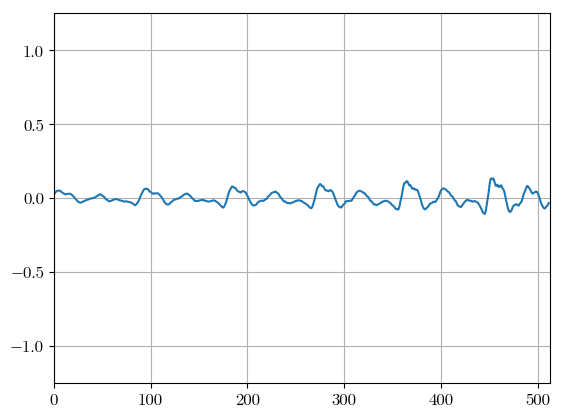

Reconstruction


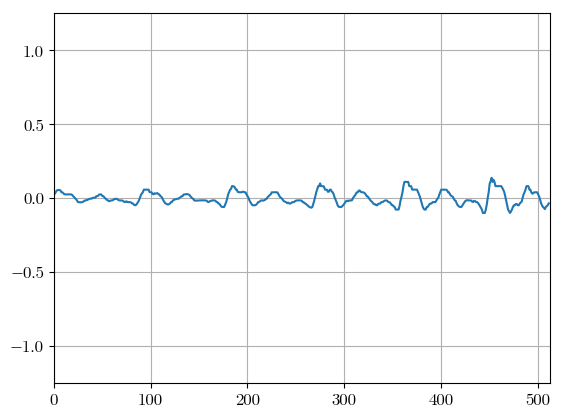

In [29]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)

## After training

In [30]:
model.fit(X_train, [X_train] * n_losses, verbose = 1, epochs = 5, batch_size = 128)

Epoch 1/5
101750/101750 [==============================] - 12s - loss: 1.1776 - model_5_loss_1: 0.0079 - model_5_loss_2: 0.9412    
Epoch 2/5
101750/101750 [==============================] - 12s - loss: 1.1145 - model_5_loss_1: 0.0068 - model_5_loss_2: 0.9113    
Epoch 3/5
101750/101750 [==============================] - 12s - loss: 1.0991 - model_5_loss_1: 0.0066 - model_5_loss_2: 0.9006    
Epoch 4/5
101750/101750 [==============================] - 12s - loss: 1.0912 - model_5_loss_1: 0.0065 - model_5_loss_2: 0.8958    
Epoch 5/5
101750/101750 [==============================] - 9s - loss: 1.0843 - model_5_loss_1: 0.0065 - model_5_loss_2: 0.8884     


In [31]:
test_model_on_wav("./SA1.wav", "SA1_quant_after", model)

MSE:         5322.36
Avg err:     20.8104
PESQ:        2.34411096573


[5322.3564, 20.810362, 2.3441109657287598]

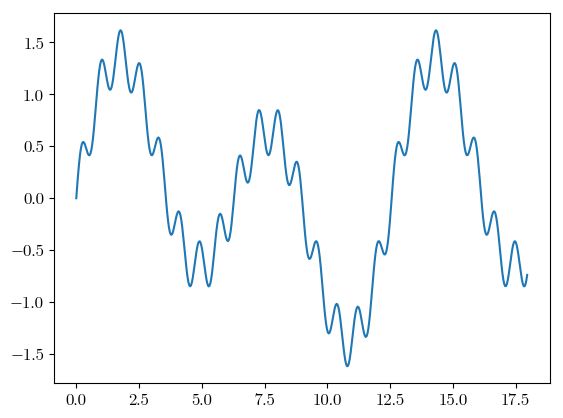

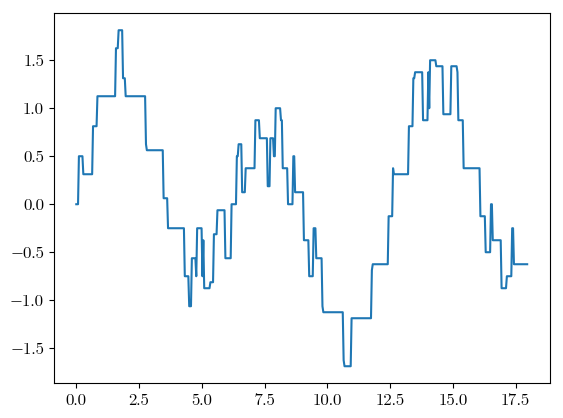

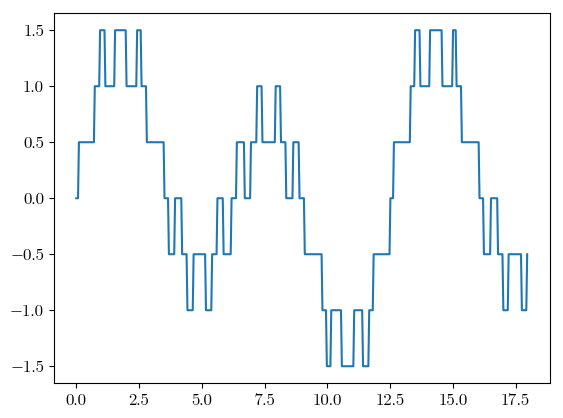

In [153]:
x = np.arange(0.0, 18.0, 18.0 / 512)
y = np.sin(x) + 0.5 * np.sin(x * 0.5) + 0.25 * np.sin(x * 8)

delta_step = 32

curr = 0.0
delta = np.zeros_like(y)
for i in xrange(0, np.size(delta), delta_step):
    d = y[i:i+delta_step] - curr
    d = np.round(d * 2.0) / 2.0
    delta[i:i+delta_step] = d
    #print i, d, curr
    
    curr += np.mean(d)

print ""
    
curr = 0.0
recovered = np.zeros_like(y)
for i in xrange(0, np.size(recovered), delta_step):
    d = delta[i:i+delta_step]
    recovered[i:i+delta_step] = d + curr
    #print i, d, curr
    
    curr += np.mean(d)

plt.plot(x, y)
plt.show()

plt.plot(x, recovered)
plt.show()

plt.plot(x, np.round(y * 2.0) / 2.0)
plt.show()

#plt.plot(x, delta)
#plt.show()

Original


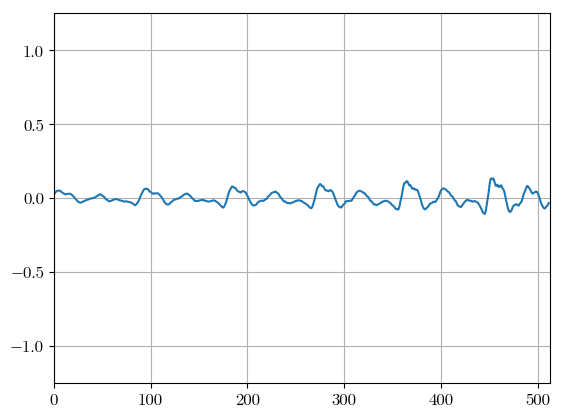

Reconstruction


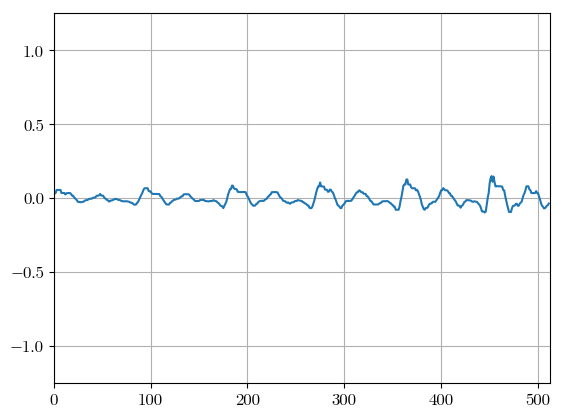

In [32]:
idx = 52

orig = X_train[idx].flatten()
recn = model.predict(X_train[idx:idx+1], verbose = 0)[0].flatten()

print "Original"
fancy_plot(orig, axes = False)

print "Reconstruction"
fancy_plot(recn, axes = False)